# Deep Learning challenge

This challenge is split into 2 independent parts:
1. CNN challenge - Face to Age
2. RNN challenge - Sentiment Analysis of Movies Reviews

## 1. CNN challenge - Face to Age

### Objectives
-  Visualize images
-  Preprocess images for Neural Networks
-  Fit a custom CNN for a regression task
-  Fine-tune an analyse model performance

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error as skmean_absolute_error

from tensorflow.keras import models, layers
from tensorflow.keras.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping


### 1.1 Visualize images

**👉 Load the dataset (200 Mo)**

In [127]:
import pandas as pd
data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/face_to_age/images.csv")
data = data.sample(frac=1, random_state=0).reset_index(drop=True)
data

,age,pixels
0,45,200 168 96 107 123 132 132 135 135 134 134 137...
1,1,223 226 231 234 236 238 238 240 240 240 240 23...
2,35,23 29 24 29 47 71 110 141 166 169 169 174 179 ...
3,28,9 6 11 12 30 65 82 37 47 16 27 26 32 74 141 16...
4,24,67 66 63 59 61 62 60 66 83 103 139 173 192 194...
...,...,...
23700,35,48 47 52 66 78 89 96 104 117 127 139 142 149 1...
23701,55,101 107 110 114 118 120 127 129 132 137 139 14...
23702,28,161 134 113 114 98 93 92 90 82 58 23 45 85 105...
23703,3,65 82 84 129 141 116 43 46 54 71 58 60 64 66 7...


Each row represent the image of a face in black and white
- `age` is the age in year
- `pixels` contains the 2304 (= 48 * 48) flatten values of each pixel in the image, in a black scale from 0 to 255, stored as string

**❓ Plot the histogram of age in your dataset.**

Text(0, 0.5, 'Count occurences')

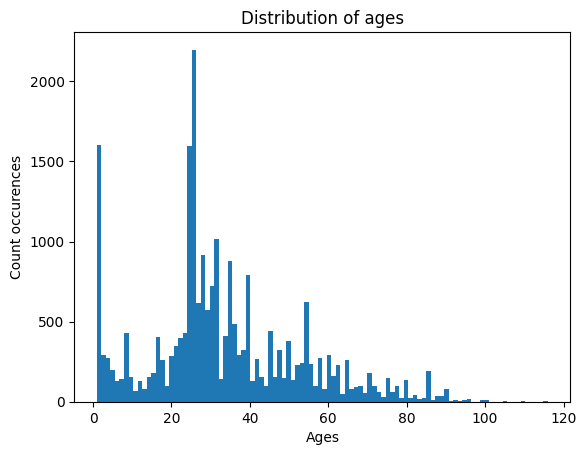

In [128]:
data.age.plot.hist(bins=100,label="Age")
plt.title('Distribution of ages')
plt.xlabel('Ages')
plt.ylabel('Count occurences')

Text(0, 0.5, 'Count occurences')

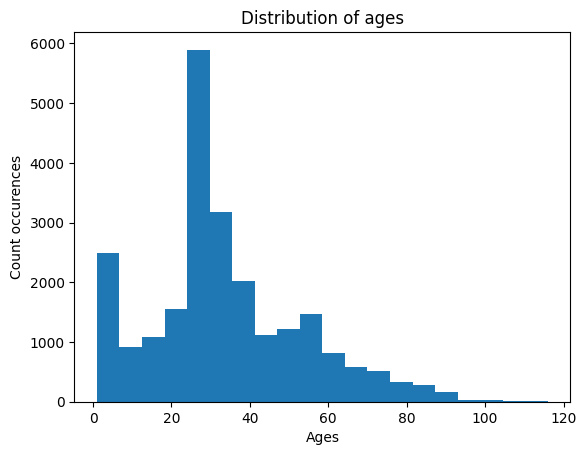

In [131]:
data.age.plot.hist(bins=20,label="Age")
plt.title('Distribution of ages')
plt.xlabel('Ages')
plt.ylabel('Count occurences')

In [132]:
data.age.mean()

33.30090698164944

**❓ Visually display one image of your choice.**

In [133]:
def plot_image(index):
    image = data.loc[index, 'pixels'] #string of chars
#     print(type(image)); print(len(image))
    image = image.split(' ') #list of chars values
#     print(type(image));  print(len(image)); print(type(image[0]))
    image = [int(pix) for pix in image] #list of values converted to integer 
#     print(type(image));  print(len(image)); print(type(image[0]))
    image_reshaped = np.array(image).reshape((48, 48))
    plt.imshow(image_reshaped, cmap='gray')




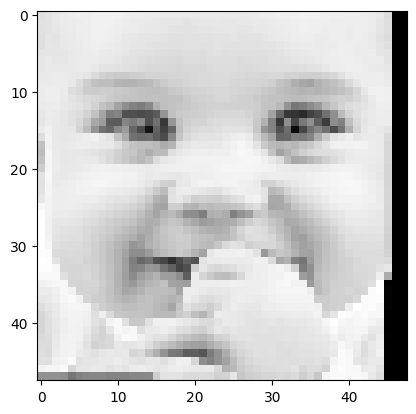

In [134]:
plot_image(1)
#my baby is cute, no ? 

**❓ What is the physical characteristic of the image at _index_ `60`?**

- Store in the 3 boolean variables `smile`/`glasses`/`hat` the values `True` if the person smiles/wears glasses/has a hat, `False` else.

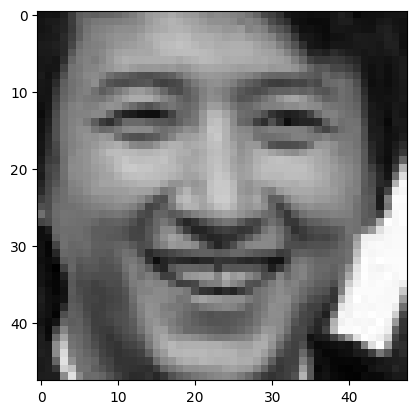

In [135]:
plot_image(60)

In [136]:
# Store your result in the variable below

smile = True
glasses = False
hat = False

#### 💾 Save your results

Run the cell below to save your results.

In [137]:
from nbresult import ChallengeResult
result = ChallengeResult('images_visualization',
                         smile=smile,
                         glasses=glasses,
                         hat=hat)
result.write()

### 1.2 Processing

**❓ Your goal is to train a convolutional neural network model to predict the _age_ of a person based solely on a picture of his/her face.**
- Create your **feature matrix** `X` as `ndarray` scaled between 0 and 1
- Create your **target vector** `y` as `ndarray`
- Create your holdout sets: 4 variables (`X_train`, `y_train`) and (`X_test`, `y_test`) keeping the **first** `70%` as the train set
- `X` and `y` shapes should fit a CNN (`model.fit(X,y)`)

😌 Don't worry, you will be given the solution in the next question in case you don't make it

In [138]:
data.shape

(23705, 2)

In [139]:
y= np.array(data.age)
print(type(y)); print(y.shape)

X = []
length=data.shape[0]
image_size=48
for idx in range(length):
    image = data.loc[idx, 'pixels']
    image = image.split(' ') #list of chars values
    image = [int(pix) for pix in image] #list of values converted to integer 
    image_reshaped = np.array(image).reshape((image_size, image_size,1))
    X.append(image_reshaped/255)

X = np.array(X)
print(X.shape)

<class 'numpy.ndarray'>
(23705,)
(23705, 48, 48, 1)


In [140]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [141]:
print(X_train.shape);print(X_test.shape);print(y_train.shape);print(y_test.shape);

(16593, 48, 48, 1)
(7112, 48, 48, 1)
(16593,)
(7112,)


#### 💾 Save your results

Run the cell below to save your results.

In [142]:
from nbresult import ChallengeResult
result = ChallengeResult('images_processing', 
                         X_train_shape = X_train.shape,
                         y_train_shape = y_train.shape,
                         first_image = X_train[0]
                        )
result.write()

### 1.3 Modeling the age of a face

👉 **Only if you haven't managed to create your training sets above**, you can start back from the solution by running the cell below 
- ⚠️ This will download ~500Mo of `.pickle` files on your current working directory
- Then it will load them into 4 ndarrays in memory, and it should delete initial .pickles from your disk

In [145]:
import pickle

def download_solutions():
    file_names = ["images_X_train.pickle", "images_X_test.pickle", "images_y_train.pickle", "images_y_test.pickle"]
    base_url = "https://wagon-public-datasets.s3.amazonaws.com/certification/face_to_age/"
    pickles = dict()

    for file_name in file_names:
        url = f"{base_url + file_name}"
        file_path = f"data/images/{file_name}"
        command = f"curl --output {file_path} {url}"
        ! eval {command}
        with open(file_path, 'rb') as handle:
            pickles[file_name] = pickle.load(handle)
        command = f"rm {file_path}"
        ! eval {command}
        
    return pickles

# UNCOMMENT THIS LINE BELOW TO GET THE CORRECTION IF NEEDED
X_train, X_test, y_train, y_test = download_solutions().values()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  291M  100  291M    0     0  7617k      0  0:00:39  0:00:39 --:--:-- 5020k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  124M  100  124M    0     0  3272k      0  0:00:39  0:00:39 --:--:-- 4861k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  129k  100  129k    0     0   335k      0 --:--:-- --:--:-- --:--:--  335k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 57039  100 57039    0     0   192k      0 --:--:-- --:--:-- --:--:--  192k


In [146]:
X_train2=X_train
X_test2=X_test
y_train2=y_train
y_test2=y_test


In [147]:
print(X_train2.shape);print(X_test2.shape);print(y_train2.shape);print(y_test2.shape);
#I was right to download solutions since my split and the Wagon split differs by 1 sample

(16594, 48, 48, 1)
(7111, 48, 48, 1)
(16594,)
(7111,)


❓ **Before training a complex model, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "naive" case where you always predict mean age
- Store the result under `score_baseline`

In [148]:
#My way
#MAE = (1/n) * sum(|y_true - y_pred|)

def my_mean_absolute_error(y_true, y_pred):
  nb_of_samples= len(y_true)
  sum = 0
  for i in range(nb_of_samples):
    sum += abs(y_true[i] - y_pred[i])
  return round(sum / nb_of_samples,1)

# Calculate the MAE
my_score_baseline = my_mean_absolute_error(y_test2, y_train2)

print(f"Baseline: {my_score_baseline} years old")


Baseline: 22.4 years old


In [152]:
#another way using sklearn mean_absolute_error
#I prefer to keep this result (15 years) since with a mean age of 33 years, a mean error of 22 years is too much

mean_age=np.mean(y_train2)
print(f"Age moyen: {mean_age} years old")
nb_of_samples= len(y_test2)
y_pred2=np.full(nb_of_samples,mean_age)
print(y_pred2.shape)
score_baseline = round(skmean_absolute_error(y_test2, y_pred2),1)

print(f"Baseline: {score_baseline} years old")


Age moyen: 33.10491744003857 years old
(7111,)
Baseline: 15.4 years old


❓ **Build and fit a convolutional neural network**

- Name it `model`
- Store output of `.fit()` in a variable `history`
- Do not use transfer learning
- Make sure your model does not overfit with appropriate control techniques

💡 Manage wisely your training time. You should obtain significantly better performance than the baseline in less than 5 minutes with average processor and no graphic cards. 

In [154]:
model = models.Sequential()
model.add(layers.Conv2D(20, kernel_size=(3, 3), input_shape=(48, 48, 1), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.Conv2D(10, kernel_size=(3, 3), activation='relu')) 
model.add(layers.MaxPool2D((2, 2))) #limit parameters with 2nd layer
model.add(layers.Flatten())
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(
    loss = 'mean_absolute_error',
    optimizer='adam'
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 20)        200       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 23, 23, 20)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 10)        1810      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 10, 10, 10)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1000)              0         
                                                                 
 dense_12 (Dense)            (None, 8)                

❓ **Plot your training and validation MAE at each epoch using the cell below**

In [155]:
es = EarlyStopping(patience = 5, restore_best_weights=True)
history = model.fit(
    X_train2, y_train2,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.2,
    callbacks=[es]
)




Epoch 1/20
415/415 [==============================] - 7s 17ms/step - loss: 16.1368 - val_loss: 14.4725
Epoch 2/20
415/415 [==============================] - 7s 17ms/step - loss: 13.6964 - val_loss: 13.1509
Epoch 3/20
415/415 [==============================] - 8s 18ms/step - loss: 12.6262 - val_loss: 11.8788
Epoch 4/20
415/415 [==============================] - 8s 19ms/step - loss: 11.9113 - val_loss: 11.4045
Epoch 5/20
415/415 [==============================] - 8s 20ms/step - loss: 11.4908 - val_loss: 11.1269
Epoch 6/20
415/415 [==============================] - 9s 21ms/step - loss: 11.2401 - val_loss: 10.7815
Epoch 7/20
415/415 [==============================] - 9s 21ms/step - loss: 11.0046 - val_loss: 10.6478
Epoch 8/20
415/415 [==============================] - 9s 21ms/step - loss: 10.8012 - val_loss: 11.7590
Epoch 9/20
415/415 [==============================] - 9s 22ms/step - loss: 10.6058 - val_loss: 10.6555
Epoch 10/20
415/415 [==============================] - 8s 20ms/step - los

In [156]:
keys = history.history.keys()
print(keys) 
value_loss = history.history['loss']
print("value_loss",value_loss)  
values_val_loss = history.history['val_loss']
print("\nvalues_val_loss",values_val_loss)  

dict_keys(['loss', 'val_loss'])
value_loss [16.136756896972656, 13.696412086486816, 12.626204490661621, 11.911253929138184, 11.49083423614502, 11.240142822265625, 11.004557609558105, 10.801246643066406, 10.60581111907959, 10.293888092041016, 10.140392303466797, 9.928832054138184, 9.706310272216797, 9.569252967834473, 9.366279602050781, 9.295146942138672, 9.122332572937012, 8.934857368469238, 8.775308609008789, 8.781112670898438]

values_val_loss [14.472526550292969, 13.150947570800781, 11.878809928894043, 11.404491424560547, 11.126872062683105, 10.781500816345215, 10.647804260253906, 11.758987426757812, 10.655527114868164, 10.402790069580078, 9.942404747009277, 9.743885040283203, 9.907421112060547, 9.491752624511719, 9.874802589416504, 9.653916358947754, 9.146921157836914, 9.148015975952148, 8.938404083251953, 9.118800163269043]


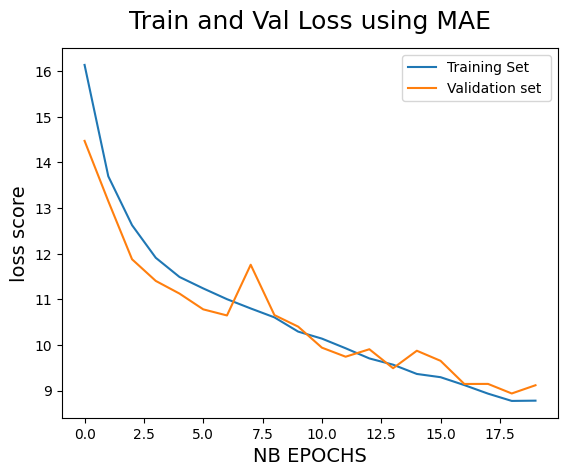

In [157]:
plt.plot(history.history['loss'], label = 'Training Set')
plt.plot(history.history['val_loss'], label = 'Validation set ')
plt.ylabel('loss score', fontsize = 14)
plt.xlabel('NB EPOCHS', fontsize = 14)
plt.title('Train and Val Loss using MAE', fontsize = 18, y = 1.03)
plt.legend()

fig = plt.gcf()
fig.savefig("tests/history.png")

❓ **Evaluate your performances on test set**
- Store your test score as `score_test`

In [158]:
score_test = round(model.evaluate(X_test, y_test),1)
score_test

223/223 [==============================] - 1s 5ms/step - loss: 9.1369


9.1

#### 💾 Save your results

Run the cell below to save your results.

In [159]:
input_shape = list(model.input.shape),
output_shape = list(model.output.shape),
layer_names = [layer.name for layer in model.layers],
trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
score_baseline = score_baseline,
score_test = score_test
    
print(input_shape)
print(output_shape)
print(layer_names)
print(trainable_params)
print(score_baseline)
print(score_test)

([None, 48, 48, 1],)
([None, 1],)
(['conv2d_4', 'max_pooling2d_4', 'conv2d_5', 'max_pooling2d_5', 'flatten_3', 'dense_12', 'dense_13'],)
(10027,)
(15.4,)
9.1


In [160]:
from nbresult import ChallengeResult
import tensorflow as tf

result = ChallengeResult(
    "cnn",
    input_shape = list(model.input.shape),
    output_shape = list(model.output.shape),
    layer_names = [layer.name for layer in model.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()

## 2. RNN challenge - Binary Sentiment Analysis of French Movie Reviews

### 2.1 Data Preparation (given)

Our dataset contains 30,000 french reviews of movies, along with the binary class 1 (positive) or 0 (negative) score

In [161]:
# We load the dataset for you
data = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews.csv')
data.head()

,review,polarity
0,Ça commence à devenir énervant d'avoir l'impre...,0
1,"J'ai aimé ce film, si il ressemble a un docume...",1
2,Une grosse merde ce haneke ce faire produire p...,0
3,"Beau mélodrame magnifiquement photographié, ""V...",1
4,A la poursuite du diamant vers est un film pro...,1


In [162]:
# We create features
y = data.polarity
X = data.review

# We analyse class balance
print(pd.value_counts(y))

1    15051
0    14900
Name: polarity, dtype: int64


In [163]:
# We check the first review
print(f'polarity: {y[0]} \n')
print(X[0])

polarity: 0 

Ça commence à devenir énervant d'avoir l'impression de voir et revoir le même genre de film à savoir : la comédie romantique, surement le genre le plus prolifique de le production française actuelle. Le problème c'est que l'on a souvent affaire à des niaiseries de faible niveau comme celui ci. Avec un scenario ultra balisé et conventionnel, c'est à se demander comment ça peut passer les portes d'un producteur. Bref cette sempiternel histoire d'un homme mentant au nom de l'amour pour reconquérir une femme et qui à la fin se prend son mensonge en pleine figure est d'une originalité affligeante, et ce n'est pas la présence au casting de l'ex miss météo Charlotte Le Bon qui rêve surement d'avoir la même carrière que Louise Bourgoin qui change la donne.


#### Text Cleaning

We performed the following data cleaning for you:
- We replaced french accents by their non-accentuated equivalent
- We reduced all uppercases to lowercases
- We removed any characters outside of a-z

Below you can visualize the cleaned dataset:

In [164]:
X_clean = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews_clean.csv")['review']
X_clean[0]

'ca commence a devenir enervant de voir et revoir le meme genre de film a savoir la comedie romantique surement le genre le plus prolifique de le production francaise actuelle le probleme que a souvent affaire a des niaiseries de faible niveau comme celui ci avec un scenario ultra balise et conventionnel a se demander comment ca peut passer les portes producteur bref cette sempiternel histoire homme mentant au nom de pour reconquerir une femme et qui a la fin se prend son mensonge en pleine figure est originalite affligeante et ce pas la presence au casting de miss meteo charlotte le bon qui reve surement la meme carriere que louise bourgoin qui change la donne'

#### Text preprocessing

Then we performed the following preprocessing for you:
- We converted each review into a list of integers, each integer representing a _unique_ word from the corpus

- We padded every sequences with a maximum length of 100, replacing missing words by `0` at the end

- For example, the sentence: `"this was good"` is converted into something like `array([1, 3, 18, 0, 0, 0, ...0], dtype=int32)` 

Below you can visualize the preprocessed dataset:

In [165]:
!curl 'https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews_preproc.csv' --output "data/movies_reviews_preproc.csv"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 71.4M  100 71.4M    0     0  12.1M      0  0:00:05  0:00:05 --:--:-- 14.2M


In [166]:
X_preproc = np.genfromtxt("data/movies_reviews_preproc.csv", delimiter=',', dtype='int32')
print(X_preproc.shape)
X_preproc[0]

(29951, 100)


array([15, 16, 17, 18, 10, 12, 10, 19, 20,  6, 10, 21, 22, 23, 10, 24, 25,
        3, 26, 27,  3, 28, 29,  6, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
        8, 40,  3, 41, 42, 43,  1, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56,  6, 57, 58, 59, 60,  8, 61,  3, 15, 62, 41, 63, 64, 65,
       66, 67, 68, 69, 70, 71,  8, 72, 73, 15, 74, 55, 75,  6, 76, 77, 78,
       10, 79, 61, 80, 18, 15, 11, 81, 25, 82, 83, 61, 84, 15, 85],
      dtype=int32)

Here is the dictionary used to translate words into integers:

In [167]:
!curl "https://wagon-public-datasets.s3.amazonaws.com/certification/movies_reviews/movies_reviews_word_to_integer.pickle" --output "data/word_to_integer.pickle"
import pickle

with open('data/word_to_integer.pickle', 'rb') as handle:
    word_to_id = pickle.load(handle)

print(len(word_to_id))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  848k  100  848k    0     0  1641k      0 --:--:-- --:--:-- --:--:-- 1644k
62379


Finally, we holdout for you a test set

In [176]:
idx_split = round(len(X_preproc)*0.7)

X_train = X_preproc[0:idx_split]
y_train = y[0:idx_split]
X_test = X_preproc[idx_split:]
y_test = y[idx_split:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(20966, 100) (20966,) (8985, 100) (8985,)


### 2.2 Modeling Sentiment Score

❓ **Before training a complex model, evaluate your baseline score**
- We will use the _accuracy_ as performance metric in this challenge
- What would be your baseline score?
- Store the result under `score_baseline`

In [177]:
#since it is a binairy target with a well distributed train set
score_baseline_RNN=0.5

❓ **Build and fit a neural network**

- Name it `model`
- Store output of `.fit()` in a variable `history`
- You **cannot** use transfer learning nor any other pre-trained models
- You must use a **Recurrent** architecture to _capture_ a notion of order in the sentences' words
- Make sure your model does not overfit with appropriate control techniques
- You don't need to cross-validate your model. Simply hold-out a validation set as you see fit
- Manage wisely your training time

💡 You will not be judged by the computing power of your computer, but you should obtain significantly better performance than the baseline in less than 5 minutes without GPUs

In [178]:
es = EarlyStopping(monitor='val_accuracy', patience = 5, restore_best_weights=True)
model_RNN = models.Sequential()
model_RNN.add(layers.Embedding(
    input_dim=len(word_to_id)+1,
    output_dim= 100,
    mask_zero=True,
))
model_RNN.add(layers.GRU(10, activation='tanh'))
model_RNN.add(layers.Dense(10, activation = 'relu'))
model_RNN.add(layers.Dense(1, activation = 'sigmoid'))

model_RNN.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

model_RNN.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         6238000   
                                                                 
 gru_4 (GRU)                 (None, 10)                3360      
                                                                 
 dense_16 (Dense)            (None, 10)                110       
                                                                 
 dense_17 (Dense)            (None, 1)                 11        
                                                                 
Total params: 6,241,481
Trainable params: 6,241,481
Non-trainable params: 0
_________________________________________________________________


In [179]:
history_RNN = model_RNN.fit(
    X_train, y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 64,
    callbacks = [es]
)

Epoch 1/10
263/263 [==============================] - 23s 77ms/step - loss: 0.4927 - accuracy: 0.7595 - val_loss: 0.3423 - val_accuracy: 0.8517
Epoch 2/10
263/263 [==============================] - 20s 77ms/step - loss: 0.2399 - accuracy: 0.9097 - val_loss: 0.3201 - val_accuracy: 0.8677
Epoch 3/10
263/263 [==============================] - 21s 82ms/step - loss: 0.1622 - accuracy: 0.9416 - val_loss: 0.5672 - val_accuracy: 0.7909
Epoch 4/10
263/263 [==============================] - 22s 82ms/step - loss: 0.1222 - accuracy: 0.9553 - val_loss: 0.3565 - val_accuracy: 0.8701
Epoch 5/10
263/263 [==============================] - 24s 90ms/step - loss: 0.0978 - accuracy: 0.9658 - val_loss: 0.2866 - val_accuracy: 0.8908
Epoch 6/10
263/263 [==============================] - 24s 93ms/step - loss: 0.0795 - accuracy: 0.9725 - val_loss: 0.3190 - val_accuracy: 0.8875
Epoch 7/10
263/263 [==============================] - 25s 95ms/step - loss: 0.0669 - accuracy: 0.9782 - val_loss: 0.3255 - val_accuracy:

In [180]:
keys = history_RNN.history.keys()
print(keys) 
value_loss = history_RNN.history['loss']
print("\nvalue_loss",value_loss)  
value_acc = history_RNN.history['accuracy']
print("\accuracy",value_acc)  

values_val_loss = history_RNN.history['val_loss']
print("\nvalues_val_loss",values_val_loss) 
value_val_acc = history_RNN.history['val_accuracy']
print("\val_accuracy",value_val_acc) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

value_loss [0.49269402027130127, 0.2398504614830017, 0.1622316837310791, 0.12218302488327026, 0.09781802445650101, 0.0795130729675293, 0.06694674491882324, 0.055787477642297745, 0.04754207283258438, 0.039265114814043045]
ccuracy [0.7594800591468811, 0.909670889377594, 0.9416289329528809, 0.9552826285362244, 0.9658359289169312, 0.972513735294342, 0.978237509727478, 0.9806820750236511, 0.9827092885971069, 0.9865251779556274]

values_val_loss [0.3422957956790924, 0.32009631395339966, 0.567234992980957, 0.35653337836265564, 0.2865557074546814, 0.3190288841724396, 0.3255425691604614, 0.3596878945827484, 0.4056589603424072, 0.3815494179725647]
al_accuracy [0.8516929149627686, 0.867668092250824, 0.7908917665481567, 0.8700524568557739, 0.8907963633537292, 0.8874582648277283, 0.8879351615905762, 0.8819742202758789, 0.8805436491966248, 0.8807820677757263]


❓ **Plot your training and validation Accuracy at each epoch using the cell below**

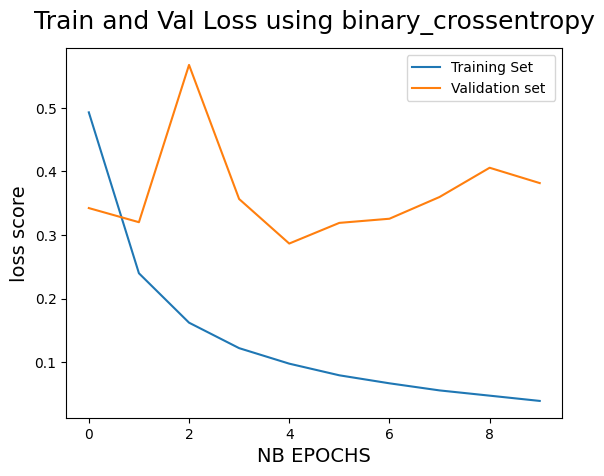

In [181]:
#I choose to make 2 plots since the dimensionnality of accuracy and loss is different

#First plot is LOSS
plt.plot(history_RNN.history['loss'], label = 'Training Set')
plt.plot(history_RNN.history['val_loss'], label = 'Validation set ')
plt.ylabel('loss score', fontsize = 14)
plt.xlabel('NB EPOCHS', fontsize = 14)
plt.title('Train and Val Loss using binary_crossentropy', fontsize = 18, y = 1.03)
plt.legend()

fig = plt.gcf()
fig.savefig("tests/history_lossRNN.png")

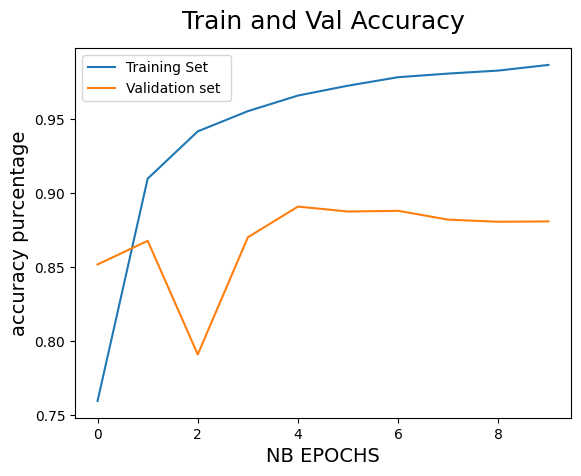

In [182]:
#Second plot is accuracy
plt.plot(history_RNN.history['accuracy'], label = 'Training Set')
plt.plot(history_RNN.history['val_accuracy'], label = 'Validation set ')
plt.ylabel('accuracy purcentage', fontsize = 14)
plt.xlabel('NB EPOCHS', fontsize = 14)
plt.title('Train and Val Accuracy', fontsize = 18, y = 1.03)
plt.legend()

fig = plt.gcf()
fig.savefig("tests/history_accuracyRNN.png")

❓ **Evaluate your performances on test set**
- Store your test score as `score_test`

In [183]:
#let's Keep accuracy
score_test = round(model_RNN.evaluate(X_test, y_test)[1],2)
score_test

281/281 [==============================] - 3s 12ms/step - loss: 0.2907 - accuracy: 0.8944


0.89

#### 💾 Save your results

Run the cell below to save your results.

In [184]:
model=model_RNN
history=history_RNN
print(model.input.shape)
print(model.output.shape)
layer_names = [layer.name for layer in model.layers]
print(layer_names)
trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
print(trainable_params)
score_baseline=score_baseline_RNN
print(score_baseline)
print(score_test)




(None, None)
(None, 1)
['embedding_4', 'gru_4', 'dense_16', 'dense_17']
(6241481,)
0.5
0.89


In [185]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "rnn",
    input_shape = list(model.input.shape),
    output_shape = list(model.output.shape),
    layer_names = [layer.name for layer in model.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in model.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()